In [377]:
import os
import pandas as pd
import numpy as np

from torch import nn
import torch
from model_mlp import dataloader, get_dataframe


In [378]:
data_dir = os.path.abspath('./data')
train_fp = os.path.join(data_dir, 'phase1.train.shuf.tsv')
df = get_dataframe(train_fp)

In [379]:
df['fold'] = np.random.choice(np.arange(5), len(df))

In [387]:
pred_frames = {}
vocabs = {}
clf_log_probs = {}
dir_output = './output'
for subdir in os.listdir(dir_output):
        if (not 'mlp' in subdir)  or ('boost' in subdir):
            continue
        fp = os.path.join(dir_output, subdir, 'pred_frame.csv')
        if not os.path.exists(fp):
            continue
        df = pd.read_csv(fp)
        pred_frames[subdir] = df
        
        fp = os.path.join(dir_output, subdir, 'vocabulary.csv')
        if os.path.exists(fp):
            with open(fp, 'r') as f:
                v = [line.strip() for line in f.readlines()]
            vocabs[subdir] = v
        else:
            fp = os.path.join(dir_output, subdir, 'vocabulary-f0.csv')
            if os.path.exists(fp):
                with open(fp, 'r') as f:
                    v = [line.strip() for line in f.readlines()]
                vocabs[subdir] = v
            

In [388]:
pred_frames.keys()

dict_keys(['model-mlp-32-sz-2500-lr-decay-0.1', 'model-mlp-1-sz-2500-lr-decay-0.1', 'model-mlp-32-sz-2500-ngrams-1-3-tf-15', 'model-mlp-32-sz-2500-ngrams-1-tf-15', 'model-mlp-64-sz-2500-ngrams-1-tf-15', 'model-mlp-32-bsz-128-sz-2500-ngrams-1-tf-15', 'model-mlp-32-sz-2500-ngrams-1-5-tf-15', 'model-mlp-author-h-32-ngrams-1-w-100', 'model-mlp-32-sz-2500-ngrams-1-3-5-tf-15', 'model-mlp-32-cross-fold-bsz-128-ngrams-1-tf-15', 'model-mlp-author-h-32-ngrams-1-3-w-100', 'model-mlp-64-sz-100-ngrams-1-tf-15', 'model-mlp-32-sz-2500-ngrams-5-tf-15', 'model-mlp-4-sz-2500-lr-decay-0.1', 'model-mlp-32-sz-2500-ngrams-3-tf-15', 'model-mlp-32-sz-2500-ngrams-1-3-5-9-tf-15', 'model-mlp-32-sz-2500-ngrams-7-9-tf-15'])

In [389]:
from sklearn import metrics

stats_frame = []
for key in pred_frames:
    pred_frame = pred_frames[key]
    if not 'score' in pred_frame.columns:
#         print(key)
#         continue
        pred_frame['score'] = np.mean(pred_frame[[f'score-f{fold}' for fold in range(5)]], 1)

    y_true, y_prob = pred_frame['assessment'], pred_frame['score']
    x,y,_ = metrics.roc_curve(y_true, y_prob, pos_label=1)
    auc = metrics.auc(x, y)
    tn = (pred_frame['score'] < 0.5) & (pred_frame['assessment'] == -1)
    fp = (pred_frame['score'] >= 0.5) & (pred_frame['assessment'] == -1)    
    fn = (pred_frame['score'] < 0.5) & (pred_frame['assessment'] == 1)
    tp = (pred_frame['score'] >= 0.5) & (pred_frame['assessment'] == 1)    
    row = {}
    row['tn'] = sum(tn)
    row['fp'] = sum(fp)
    row['fn'] = sum(fn)
    row['tp'] = sum(tp)
    row['auc'] = auc
    row['exp'] = key
    stats_frame.append(row)
stats_frame = pd.DataFrame(stats_frame)

In [390]:
stats_frame['specificity'] = stats_frame['tn'] / (stats_frame['tn'] + stats_frame['fp']) 
stats_frame['precision'] = stats_frame['tp'] / (stats_frame['tp'] + stats_frame['fp']) 
stats_frame['recall'] = stats_frame['tp'] / (stats_frame['tp'] + stats_frame['fn']) 
stats_frame['f1'] = (2 * stats_frame['precision'] * stats_frame['recall']) / (stats_frame['precision'] + stats_frame['recall']) 
stats_frame.fillna(0, inplace=True)

In [391]:
pd.set_option('max_colwidth', 500)

In [399]:
stats_frame.sort_values(by='f1', ascending=False).head(5)

,tn,fp,fn,tp,auc,exp,specificity,precision,recall,f1
7,4644,56,85,65,0.921058,model-mlp-author-h-32-ngrams-1-w-100,0.988085,0.537190,0.433333,0.479705
2,4521,179,49,101,0.922516,model-mlp-32-sz-2500-ngrams-1-3-tf-15,0.961915,0.360714,0.673333,0.469767
8,4487,213,51,99,0.939088,model-mlp-32-sz-2500-ngrams-1-3-5-tf-15,0.954681,0.317308,0.660000,0.428571
0,4458,242,44,106,0.922670,model-mlp-32-sz-2500-lr-decay-0.1,0.948511,0.304598,0.706667,0.425703
15,4513,187,59,91,0.924634,model-mlp-32-sz-2500-ngrams-1-3-5-9-tf-15,0.960213,0.327338,0.606667,0.425234


In [136]:
stats_frame.sort_values(by='precision', ascending=False).head(5)

,tn,fp,fn,tp,auc,exp,specificity,precision,recall,f1
12,4700,0,145,5,0.900763,model-mlp-32-cross-fold-bsz-128-ngrams-1-tf-15,1.000000,1.000000,0.033333,0.064516
13,4686,14,119,31,0.915782,model-mlp-author-h-32-ngrams-1-3-w-100,0.997021,0.688889,0.206667,0.317949
1,4666,34,99,51,0.919157,model-mlp-boost-init-h-32-ngrams-1-w-100,0.992766,0.600000,0.340000,0.434043
3,4646,54,85,65,0.897846,model-boost-h-32-ngrams-1,0.988511,0.546218,0.433333,0.483271
14,4646,54,85,65,0.926015,model-boost-01-h-8-ngrams-1,0.988511,0.546218,0.433333,0.483271


In [137]:
stats_frame.sort_values(by='tp', ascending=False).head(5)

,tn,fp,fn,tp,auc,exp,specificity,precision,recall,f1
15,3742,958,35,115,0.867649,model-mlp-64-sz-100-ngrams-1-tf-15,0.796170,0.107176,0.766667,0.188062
5,4409,291,41,109,0.942176,model-mlp-32-sz-2500-ngrams-1-tf-15,0.938085,0.272500,0.726667,0.396364
0,4458,242,44,106,0.922670,model-mlp-32-sz-2500-lr-decay-0.1,0.948511,0.304598,0.706667,0.425703
7,4432,268,44,106,0.943582,model-mlp-32-bsz-128-sz-2500-ngrams-1-tf-15,0.942979,0.283422,0.706667,0.404580
17,4408,292,45,105,0.924381,model-mlp-4-sz-2500-lr-decay-0.1,0.937872,0.264484,0.700000,0.383912


In [138]:
stats_frame.sort_values(by='recall', ascending=False).head(5)

,tn,fp,fn,tp,auc,exp,specificity,precision,recall,f1
15,3742,958,35,115,0.867649,model-mlp-64-sz-100-ngrams-1-tf-15,0.796170,0.107176,0.766667,0.188062
5,4409,291,41,109,0.942176,model-mlp-32-sz-2500-ngrams-1-tf-15,0.938085,0.272500,0.726667,0.396364
0,4458,242,44,106,0.922670,model-mlp-32-sz-2500-lr-decay-0.1,0.948511,0.304598,0.706667,0.425703
7,4432,268,44,106,0.943582,model-mlp-32-bsz-128-sz-2500-ngrams-1-tf-15,0.942979,0.283422,0.706667,0.404580
17,4408,292,45,105,0.924381,model-mlp-4-sz-2500-lr-decay-0.1,0.937872,0.264484,0.700000,0.383912


/home/dean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


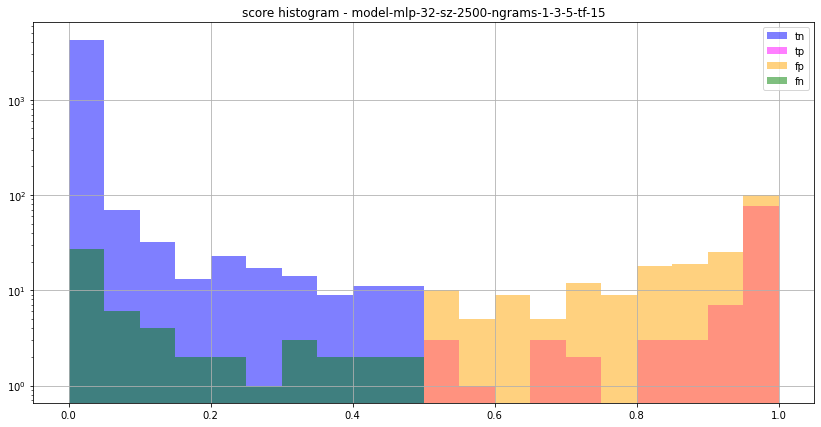

In [193]:
import matplotlib.pyplot as plt
sc = pred_frames[subdir]['score']
tg = pred_frames[subdir]['assessment']

fig, ax = plt.subplots(figsize=(14, 7))
bins = np.arange(0.0, 1.01, 0.05)
ax.hist(sc[(tg == -1) & (sc < 0.5)], bins, color='blue', alpha=0.5, label='tn')
ax.hist(sc[(tg == 1) & (sc >= 0.5)], bins, color='magenta', alpha=0.5, label='tp')
ax.hist(sc[(tg == -1) & (sc >= 0.5)], bins, color='orange', alpha=0.5, label='fp')
ax.hist(sc[(tg == 1) & (sc < 0.5)], bins, color='green', alpha=0.5, label='fn')
ax.set_yscale('log', nonposy='clip')
ax.set_title(f'score histogram - {subdir}')
ax.legend()
ax.grid()
plt.show()

/home/dean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


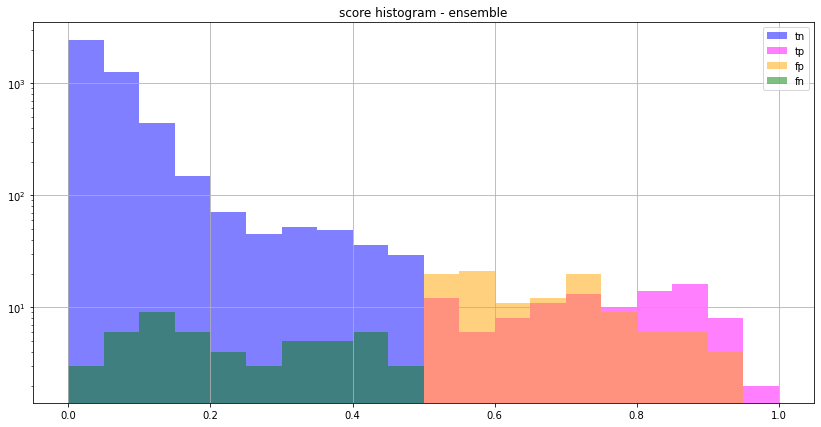

In [195]:
import matplotlib.pyplot as plt
sc = ens_frame['score']
tg = ens_frame['assessment']

fig, ax = plt.subplots(figsize=(14, 7))
bins = np.arange(0.0, 1.01, 0.05)
ax.hist(sc[(tg == -1) & (sc < 0.5)], bins, color='blue', alpha=0.5, label='tn')
ax.hist(sc[(tg == 1) & (sc >= 0.5)], bins, color='magenta', alpha=0.5, label='tp')
ax.hist(sc[(tg == -1) & (sc >= 0.5)], bins, color='orange', alpha=0.5, label='fp')
ax.hist(sc[(tg == 1) & (sc < 0.5)], bins, color='green', alpha=0.5, label='fn')
ax.set_yscale('log', nonposy='clip')
ax.set_title(f'score histogram - ensemble')
ax.legend()
ax.grid()
plt.show()

In [618]:
vocab = vocabs[subdir]
['study',
 'health',
 'female',
 'male',
 'humans',
 'care',
 'adult',
 'studies',
 'results',
 'human',
 'medical',
 'education',
 'patients',
 'clinical',
 'hospital',
 'data',
 'aged',
 'research',
 'methods',
 'population',
 'factors',
 'practice',
 'disease',
 'risk',
 'among',
 'analysis',
 'years',
 'use',
 'patient',
 'age',
 'article',
 'epidemiology',
 'treatment',
 'support',
 'one',
 'also',
 'control',
 'countries',
 'middle',
 'adolescent',
 'personnel',
 'services',
 'prevention',
 'used',
 'may',
 'using',
 'associated',
 'community',
 'major',
 'group',
 'high',
 'therapy',
 'hospitals',
 'higher',
 'two',
 'child',
 'women',
 'survey',
 'found',
 'conclusion',
 'information',
 'conclusions',
 'objective',
 'developing',
 'however',
 'significant',
 'well',
 'prevalence',
 'cases',
 'significantly',
 'rate',
 'compared',
 'drug',
 'knowledge',
 'diagnosis',
 'time',
 'statistics',
 "gov't",
 'public',
 'development',
 'family',
 'service',
 'determine',
 'non-u',
 'quality',
 'background',
 'need',
 'assessment',
 'infection',
 'total',
 'reported',
 'questionnaires',
 'level',
 'questionnaire',
 'primary',
 'important',
 'design',
 'system',
 'groups',
 'number',
 'blood',
 'children',
 'administration',
 'status',
 'social',
 'attitudes',
 'university',
 'training',
 'findings',
 'new',
 'attitude',
 'diseases',
 'management',
 'based',
 'general',
 'physicians',
 'program',
 'united',
 'national',
 'period',
 'programs',
 'first',
 'organization',
 'medicine',
 'effects',
 'characteristics',
 'less',
 'sex',
 'priority',
 'conducted',
 'three',
 'setting',
 'many',
 'intervention',
 'common',
 'controlled',
 'planning',
 'included',
 'although',
 'mean',
 'role',
 'different',
 'review',
 'including',
 'psychology',
 'numerical',
 'subjects',
 'english',
 'effective',
 'main',
 'educational',
 'levels',
 'related',
 'behavior',
 'infant',
 'performed',
 'developed',
 'respectively',
 'work',
 'paper',
 'mortality',
 'infections',
 'abstract',
 'needs',
 'provide',
 'low',
 'report',
 'increased',
 'overall',
 'life',
 'could',
 'comparative',
 'nursing',
 'factor',
 'problems',
 'south',
 'people',
 'sample',
 'identified',
 'within',
 'world',
 'outcome',
 'year',
 'retrospective',
 'showed',
 'method',
 'workers',
 'experience',
 'evaluation',
 'aim',
 'professional',
 'improve',
 'complications',
 'per',
 'measures',
 'students',
 'therapeutic',
 'early',
 'selected',
 'africa',
 'would',
 'differences']
ix_important = [vocab.index(term) for term in important]

In [414]:
fc_weights = list(net.modules())[0].fc.weight.detach().numpy()

from sklearn.decomposition import PCA

pca = PCA(n_components=min(2, max(1, dim_h)))
w_pca = pca.fit_transform(fc_weights.transpose())

In [619]:
from scipy.spatial import distance_matrix

dist = -distance_matrix(w_pca[ix_important, :], w_pca, p=1)

topk_dists = np.argpartition(dist, 25, axis=1)[:, :25]

ix_topk_dists = list(np.unique(topk_dists))

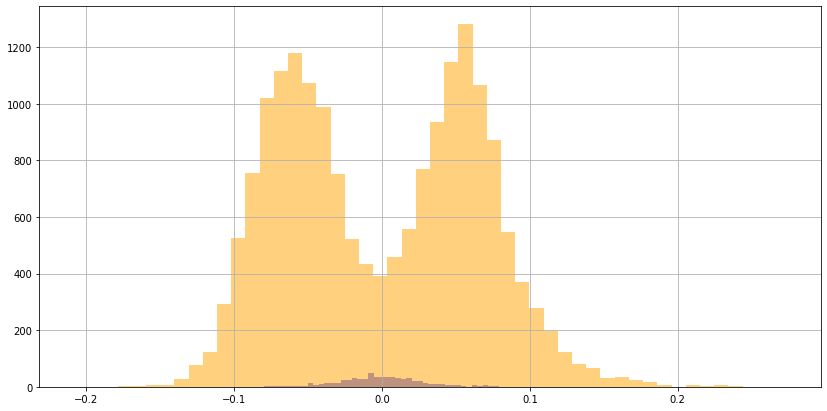

In [687]:

fig, ax = plt.subplots(figsize=(14, 7))
ax.hist(fc_weights[:, ix_important].flatten(), bins=50, color='blue', alpha=0.5)
ax.hist(fc_weights[:, ix_topk_dists].flatten(), bins=50, color='orange', alpha=0.5)
ax.grid()
plt.show()

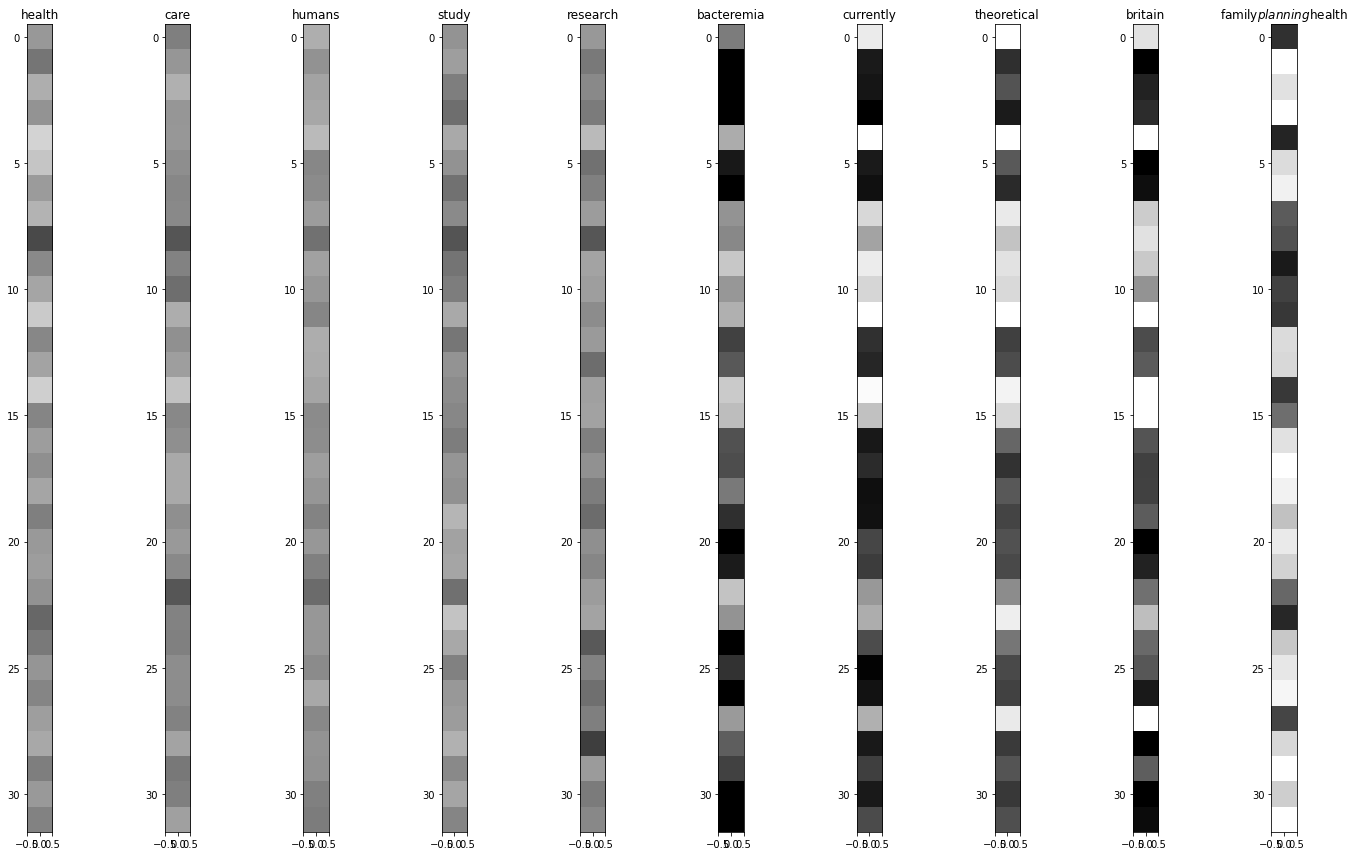

In [146]:

import matplotlib.colors as colors

norm = colors.Normalize(vmin=-0.05, vmax=0.05)

vocab = vocabs[subdir]

indices = ix_important[:5] + ix_topk_dists[:5]

fc_weights = list(net.modules())[0].fc.weight.detach().numpy()
fig, ax = plt.subplots(1, len(indices), figsize=(20, 12))
for ix, i in enumerate(indices):
    ax[ix].imshow(fc_weights[:, i, None], cmap='gray', norm=norm)
    ax[ix].set_title(vocabs[subdir][i])
fig.tight_layout()
plt.show()

In [40]:
ix_important = [vocab.index(term) for term in important]
ix_other = [vocab.index(term) for term in vocab if not term in important]

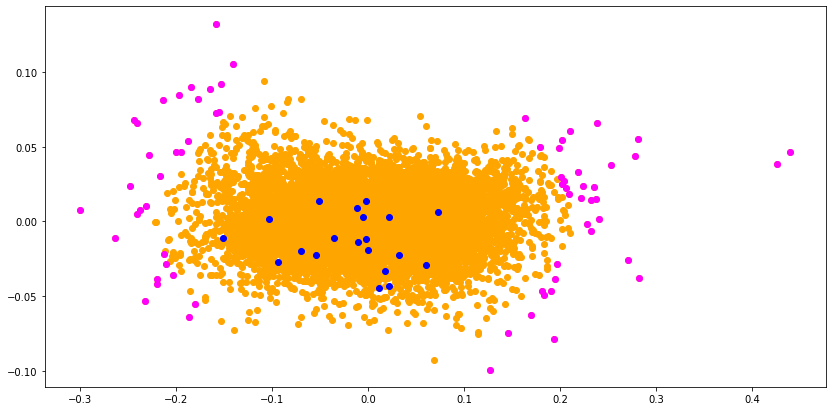

In [41]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(w_pca[ix_other, 0], w_pca[ix_other, 1], c='orange')  
ax.scatter(w_pca[ix_topk_dists, 0], w_pca[ix_topk_dists, 1], c='magenta')  
ax.scatter(w_pca[ix_important, 0], w_pca[ix_important, 1], c='blue')

In [176]:
import matplotlib as mpl
import torch

ns = [1, 3, 5]

indices_fn = pred_frames[subdir][fn].sort_values(by=['assessment', 'score'], ascending=True).index
indices_tp = pred_frames[subdir][tp].sort_values(by=['assessment', 'score'], ascending=True).index
fp = (pred_frames[subdir]['score'] >= 0.5) & (pred_frames[subdir]['assessment'] == -1)
indices_fp = pred_frames[subdir][fp].sort_values(by=['assessment', 'score'], ascending=True).index
indices_tn = pred_frames[subdir][tn].sort_values(by=['assessment', 'score'], ascending=True).index

class MLPHook(torch.nn.Module):

    def __init__(self, dim_in, dim_h, dim_out):
        super(MLPHook, self).__init__()
        self.fc = nn.Linear(dim_in, dim_h)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm1d(dim_h)
        self.dense = nn.Linear(dim_h, dim_out)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.to(torch.float)
        x = self.fc(x)
        c = x.clone()
        x = self.relu(x)
        x = self.bn(x)
        x = self.dense(x)
        return x, c
    
dim_h = int(subdir.split('mlp-')[1].split('-')[0])
dim_in, dim_h, dim_out = (len(vocabs[subdir]), dim_h, 2)
net = MLPHook(dim_in, dim_h, dim_out)
fp = os.path.join('./output', subdir, 'weights.pt')
state_dict = torch.load(fp)
net.load_state_dict(state_dict)

vocab = vocabs[subdir]

activations_fn = []
for i in indices_fn:
    df_i = pd.DataFrame([df.iloc[i]])
    x, y = dataloader(df_i, vocab, ns=ns)
    xd = np.copy(x)
    
    net.eval()
    with torch.no_grad():
        xi = torch.Tensor(xd)
        output, activation = net(xi)        
        activations_fn.append(activation.flatten().numpy())

activations_tp = []
for i in indices_tp:
    df_i = pd.DataFrame([df.iloc[i]])
    x, y = dataloader(df_i, vocab, ns=ns)
    xd = np.copy(x)
    
    net.eval()
    with torch.no_grad():
        xi = torch.Tensor(xd)
        output, activation = net(xi)        
        activations_tp.append(activation.flatten().numpy())
        
activations_fp = []
for i in indices_fp:
    df_i = pd.DataFrame([df.iloc[i]])
    x, y = dataloader(df_i, vocab, ns=ns)
    xd = np.copy(x)
    
    net.eval()
    with torch.no_grad():
        xi = torch.Tensor(xd)
        output, activation = net(xi)        
        activations_fp.append(activation.flatten().numpy())
        
activations_tn = []
for i in indices_tn:
    df_i = pd.DataFrame([df.iloc[i]])
    x, y = dataloader(df_i, vocab, ns=ns)
    xd = np.copy(x)
    
    net.eval()
    with torch.no_grad():
        xi = torch.Tensor(xd)
        output, activation = net(xi)        
        activations_tn.append(activation.flatten().numpy())

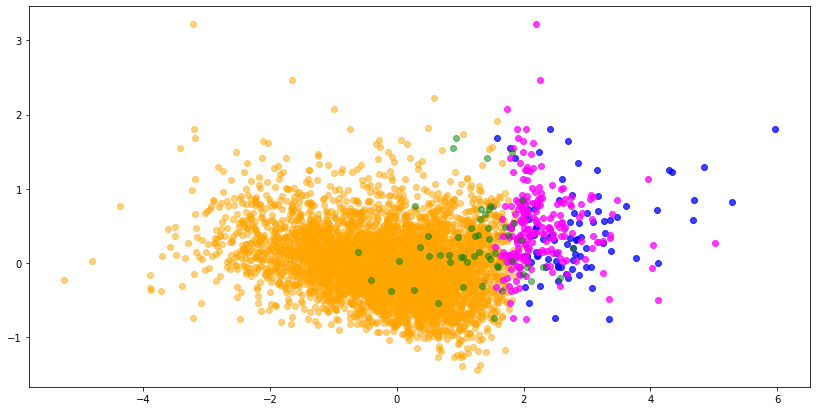

In [188]:
activations = np.concatenate([
    np.array(activations_tp),
    np.array(activations_tn),
    np.array(activations_fp),
    np.array(activations_fn)])

pca = PCA(n_components=2)
a_pca = pca.fit_transform(activations)

fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(a_pca[np.arange(len(activations_tp)), 0], a_pca[np.arange(len(activations_tp)), 1], alpha=0.75, c='blue')
s = len(activations_tp)
e = len(activations_tp) + len(activations_tn)
ax.scatter(a_pca[np.arange(s, e), 0], a_pca[np.arange(len(activations_tn)), 1], alpha=0.5, c='orange')
s = e
e = e + len(activations_fp)
ax.scatter(a_pca[np.arange(s, e), 0], a_pca[np.arange(len(activations_fp)), 1], alpha=0.75, c='magenta')
s = e
e = e + len(activations_fn)
ax.scatter(a_pca[np.arange(s, e), 0], a_pca[np.arange(len(activations_fn)), 1], alpha=0.5, c='green')

Populating feature vectors...


1it [00:00, 37.66it/s]

0
tensor([[1.4863e-06, 1.0000e+00]]) pred: 1 label: -1

10
tensor([[5.8935e-06, 9.9999e-01]]) pred: 1 label: -1

20
tensor([[1.9961e-04, 9.9980e-01]]) pred: 1 label: -1

30
tensor([[3.1825e-04, 9.9968e-01]]) pred: 1 label: -1

40
tensor([[0.0093, 0.9907]]) pred: 1 label: -1

50
tensor([[0.0804, 0.9196]]) pred: 1 label: -1

60
tensor([[0.8321, 0.1679]]) pred: -1 label: -1

70
tensor([[0.9547, 0.0453]]) pred: -1 label: -1

80
tensor([[0.9877, 0.0123]]) pred: -1 label: -1

90
tensor([[0.9876, 0.0124]]) pred: -1 label: -1



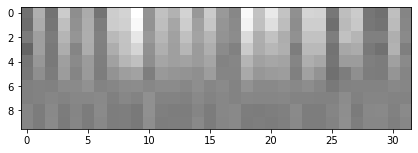

126 tensor([0.3852, 0.6148]) pred: 1 label: -1


In [166]:
import torch
i = 812
vocab = vocabs[subdir]
df_i = pd.DataFrame([df.iloc[i]])
x, y = dataloader(df_i, vocab, ns=[1,3])
xd = np.copy(x)


class MLPHook(torch.nn.Module):

    def __init__(self, dim_in, dim_h, dim_out):
        super(MLPHook, self).__init__()
        self.fc = nn.Linear(dim_in, dim_h)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm1d(dim_h)
        self.dense = nn.Linear(dim_h, dim_out)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.to(torch.float)
        x = self.fc(x)
        c = x.clone()
        x = self.relu(x)
        x = self.bn(x)
        x = self.dense(x)
        return x, c
    
dim_h = int(subdir.split('mlp-')[1].split('-')[0])
dim_in, dim_h, dim_out = (len(vocabs[subdir]), dim_h, 2)
net = MLPHook(dim_in, dim_h, dim_out)

fp = os.path.join('./output', subdir, 'weights.pt')
state_dict = torch.load(fp)

net.load_state_dict(state_dict)
import matplotlib as mpl
activations = []
scores = []
for d_out in range(0, 100, 10):
    ix_tokens = x.nonzero()[1]
    ix_dropout = np.random.choice(ix_tokens, d_out)
    xd[:, ix_dropout] = 0

    net.eval()
    with torch.no_grad():
        xi = torch.Tensor(xd)
        output, activation = net(xi)

    score = torch.softmax(output, 1)
    pred = -1 if torch.argmax(output, 1)[0] == 0 else 1
    
    print(d_out)
    print(score, f'pred: {pred}',  f'label: {y[0]}')
    print()
    scores.append(score)
    activations.append(activation.flatten().numpy())
        
fig, ax = plt.subplots(figsize=(7, 5))
ax.imshow(
    np.stack(activations, 0),
    cmap='gray',
    norm=mpl.colors.Normalize(vmin=-1.,vmax=1.))
plt.show()

agg_score = torch.cat(scores).mean(0)
pred = -1 if torch.argmax(agg_score, 0).item == 0 else 1
print(f'{len(ix_tokens)} {agg_score} pred: {pred}',  f'label: {y[0]}')

In [47]:
# 1: weights correlated with p/n predictions

import torch

data_dir = os.path.abspath('./data')
dev_fp = os.path.join(data_dir, 'phase1.dev.shuf.tsv')
df = get_dataframe(dev_fp)

class MLPHook(torch.nn.Module):

    def __init__(self, dim_in, dim_h, dim_out):
        super(MLPHook, self).__init__()
        self.fc = nn.Linear(dim_in, dim_h)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm1d(dim_h)
        self.dense = nn.Linear(dim_h, dim_out)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.to(torch.float)
        x = self.fc(x)
        c = x.clone()
        x = self.relu(x)
        x = self.bn(x)
        x = self.dense(x)
        return x, c
    

subdirs = [
    'model-mlp-author-h-32-ngrams-1-w-100',
    'model-mlp-32-sz-2500-ngrams-1-3-tf-15',
    'model-mlp-32-sz-2500-ngrams-1-3-5-tf-15']
ns = [[1,], [1,3], [1,3,5]]

nets = {}
vocs = {}
for i, subdir in enumerate(subdirs):
    nets[subdir] = {}
    vocs[subdir] = {}
    
    vocab = vocabs[subdir]
  
    fp = os.path.join('./output', subdir, 'weights.pt')
    if not os.path.exists(fp):
        folds = list(range(5))
    else:
        folds = [0,]
    for fold in folds:
        if len(folds) > 1:
            # fold vocab
            fp = os.path.join(dir_output, subdir, f'vocabulary-f{fold}.csv')
            with open(fp, 'r') as f:
                vocab = [line.strip() for line in f.readlines()]
            # fold state dict
            fp = os.path.join('./output', subdir, f'state_dict-f{fold}.pt')
        else:
            pass
        
        dim_h = 32
        dim_in, dim_h, dim_out = (len(vocab), dim_h, 2)
        net = MLPHook(dim_in, dim_h, dim_out)
    
        state_dict = torch.load(fp)
        net.load_state_dict(state_dict)
    
        nets[subdir][fold] = net
        vocs[subdir][fold] = vocab

ens_stack = []

# count largest activation by pred
avg_activation = {
    (-1, -1): np.zeros((dim_h)),
    (1, 1): np.zeros((dim_h)),
    (-1, 1): np.zeros((dim_h)),
    (1, -1): np.zeros((dim_h)),
}
topk_abs_argmax = {
    (-1, -1): np.zeros((dim_h)),
    (1, 1): np.zeros((dim_h)),
    (-1, 1): np.zeros((dim_h)),
    (1, -1): np.zeros((dim_h)),
}
topk_argmax = {
    (-1, -1): np.zeros((dim_h)),
    (1, 1): np.zeros((dim_h)),
    (-1, 1): np.zeros((dim_h)),
    (1, -1): np.zeros((dim_h)),
}
denom = {k: 0 for k in avg_activation}

for i, subdir in enumerate(subdirs[:1]):
    xd = {}
    ens_pred = []
    
    folds = vocs[subdir].keys()
    for fold in folds:
        x, y = dataloader(pred_frames[subdir].sample(1000), vocs[subdir][fold], ns=ns[i], add_authors='author' in subdir)
        xd[fold] = np.copy(x)

    for sample_ix in range(1000):
        sample = xd[fold][sample_ix][None, :]

        net = nets[subdir][fold]
        net.eval()
        with torch.no_grad():
            xi = torch.Tensor(sample)
            output, activation = net(xi)
            score = torch.softmax(output, 1)
        pred = torch.argmax(score).item()
        pred = -1 if pred == 0 else 1
        label = y[sample_ix]
        # track abs
        topk = torch.topk(torch.abs(activation), 5)
        for ix_activation in topk[1]:
            topk_abs_argmax[(pred, label)][ix_activation] += 1
        # track signed
        topk = torch.topk(activation, 5)
        for ix_activation in topk[1]:
            topk_argmax[(pred, label)][ix_activation] += 1
        # track avg of activations
        avg_activation[(pred, label)] += activation[0].numpy()
        denom[(pred, label)] += 1

In [48]:
for key in denom:
    avg_activation[key] /= denom[key]

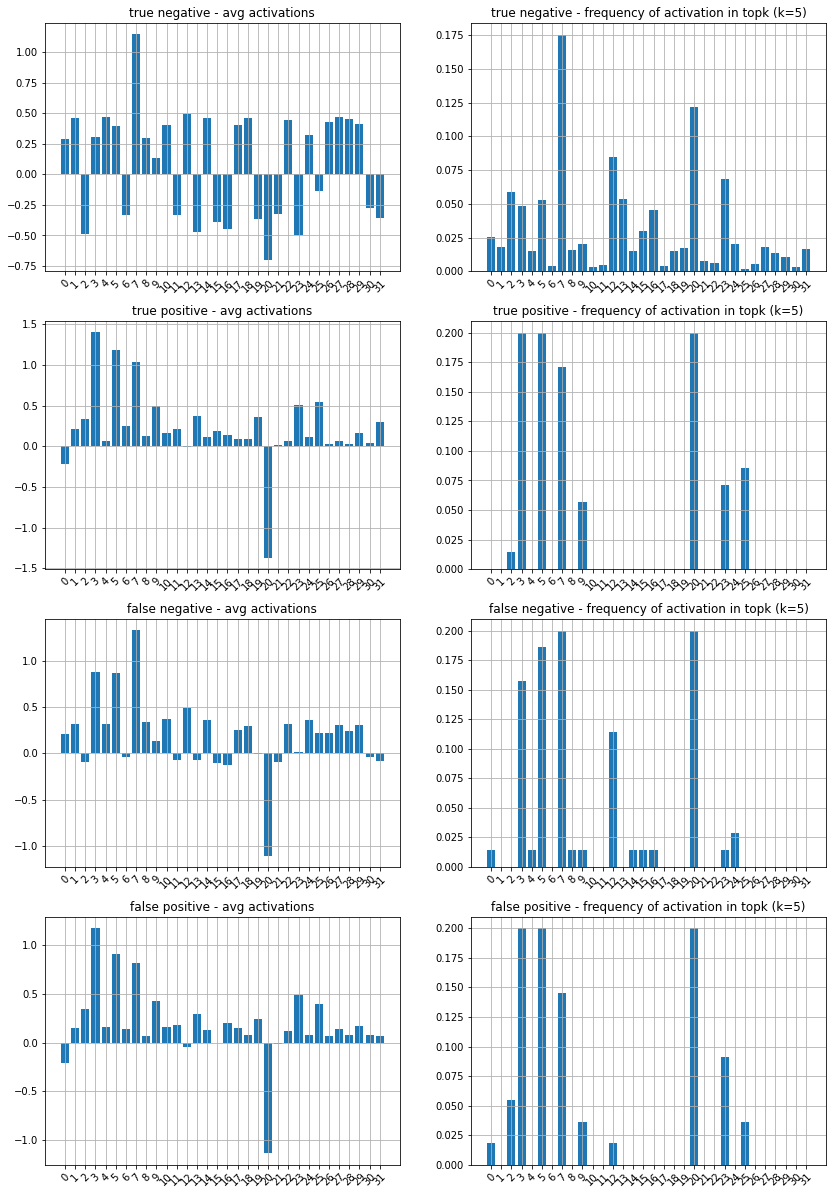

In [50]:
import matplotlib.pyplot as plt

title = {
    (-1, -1): 'true negative',
    (-1, 1): 'false negative',
    (1, 1): 'true positive',
    (1, -1): 'false positive',
}
k = 5
fig, ax = plt.subplots(len(avg_activation), 2, figsize=(14, 21))
for i, key in enumerate(avg_activation):
    # avg activation per prediction class
    act = avg_activation[key]
    x = np.arange(len(act))
    ax[i, 0].bar(x, act)
    ax[i, 0].set_title(f'{title[key]} - avg activations')
    ax[i, 0].set_xticks(x)
    ax[i, 0].set_xticklabels(x, rotation=45)
    ax[i, 0].grid()
    
    # frequency activation is in top k
    count_weights = topk_abs_argmax[key]
    x = np.arange(len(count_weights))
    ax[i, 1].bar(x, count_weights / count_weights.sum())
    ax[i, 1].set_title(f'{title[key]} - frequency of activation in topk (k={k})')
    ax[i, 1].set_xticks(x)
    ax[i, 1].set_xticklabels(x, rotation=45)
    ax[i, 1].grid()
fig.suptitle('average activations')
plt.show()

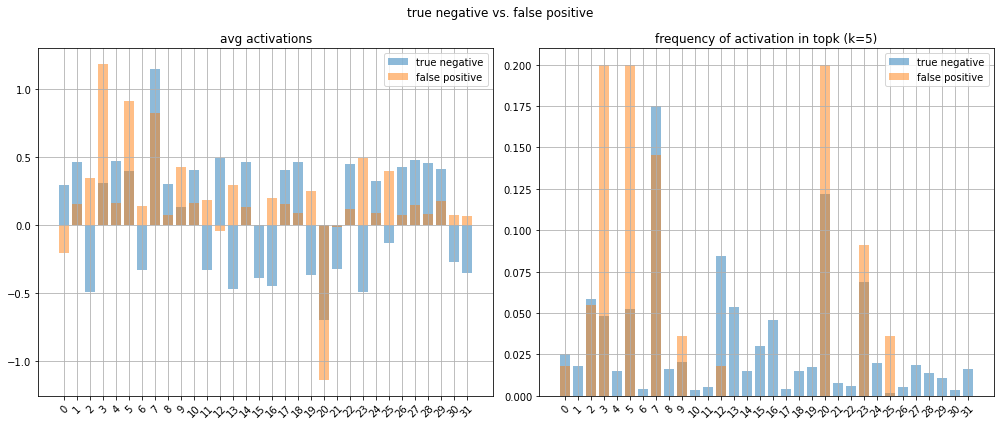

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# overlay average activations
keys = [(-1, -1), (1, -1)]
for key in keys:
    act = avg_activation[key]
    x = np.arange(len(act))
    ax[0].bar(x, act, alpha=0.5, label=title[key])
    ax[0].set_title(f'avg activations')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(x, rotation=45)

    # frequency activation is in top k
    count_weights = topk_abs_argmax[key]
    x = np.arange(len(count_weights))
    ax[1].bar(x, count_weights / count_weights.sum(), alpha=0.5, label=title[key])
    ax[1].set_title(f'frequency of activation in topk (k={k})')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(x, rotation=45)

ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
fig.suptitle(f'{title[keys[0]]} vs. {title[keys[1]]}')
fig.tight_layout()
plt.show()

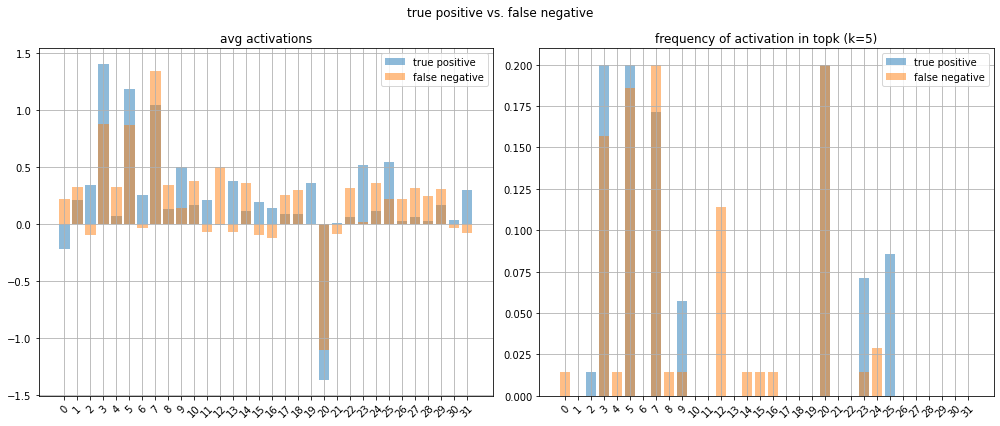

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# overlay average activations
keys = [(1, 1), (-1, 1)]
for key in keys:
    act = avg_activation[key]
    x = np.arange(len(act))
    ax[0].bar(x, act, alpha=0.5, label=title[key])
    ax[0].set_title(f'avg activations')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(x, rotation=45)

    # frequency activation is in top k
    count_weights = topk_abs_argmax[key]
    x = np.arange(len(count_weights))
    ax[1].bar(x, count_weights / count_weights.sum(), alpha=0.5, label=title[key])
    ax[1].set_title(f'frequency of activation in topk (k={k})')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(x, rotation=45)

ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
fig.suptitle(f'{title[keys[0]]} vs. {title[keys[1]]}')
fig.tight_layout()
plt.show()

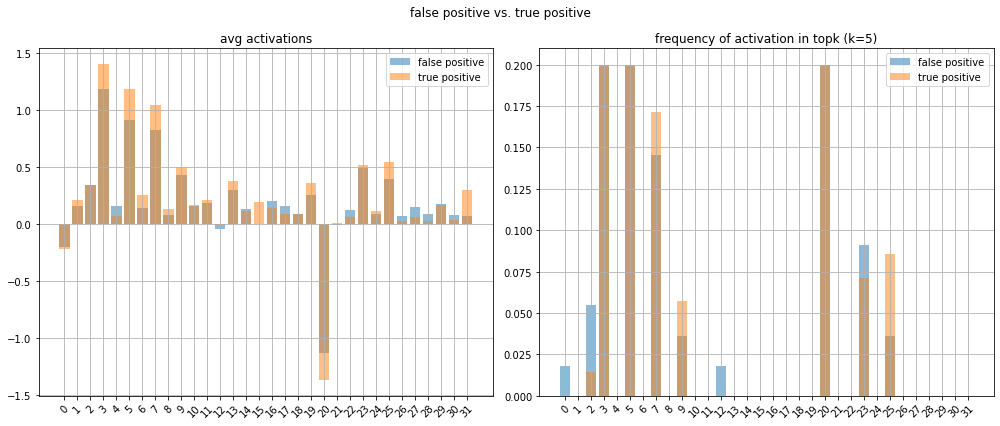

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# overlay average activations
keys = [(1, -1), (1, 1)]
for key in keys:
    act = avg_activation[key]
    x = np.arange(len(act))
    ax[0].bar(x, act, alpha=0.5, label=title[key])
    ax[0].set_title(f'avg activations')
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(x, rotation=45)

    # frequency activation is in top k
    count_weights = topk_abs_argmax[key]
    x = np.arange(len(count_weights))
    ax[1].bar(x, count_weights / count_weights.sum(), alpha=0.5, label=title[key])
    ax[1].set_title(f'frequency of activation in topk (k={k})')
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(x, rotation=45)

ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
fig.suptitle(f'{title[keys[0]]} vs. {title[keys[1]]}')
fig.tight_layout()
plt.show()

In [860]:
import torch

data_dir = os.path.abspath('./data')
dev_fp = os.path.join(data_dir, 'phase1.dev.shuf.tsv')
df = get_dataframe(dev_fp)

class MLPHook(torch.nn.Module):

    def __init__(self, dim_in, dim_h, dim_out):
        super(MLPHook, self).__init__()
        self.fc = nn.Linear(dim_in, dim_h)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm1d(dim_h)
        self.dense = nn.Linear(dim_h, dim_out)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, ix, patch):
        x = x.to(torch.float)
        x = self.fc(x)    
        x[:, ix] = patch
        c = x.clone()
        x = self.relu(x)
        x = self.bn(x)
        x = self.dense(x)
        return x, c
    

subdirs = [
    'model-mlp-author-h-32-ngrams-1-w-100',
    'model-mlp-32-sz-2500-ngrams-1-3-tf-15',
    'model-mlp-32-sz-2500-ngrams-1-3-5-tf-15']
subdir = subdirs[0]

# pred_frame = pred_frames[subdir].reset_index()
# pred_frame = pred_frame.merge(train_df.reset_index()[['index', 'authors']], on='index')

ns = [[1,], [1,3], [1,3,5]]

nets = {}
vocs = {}
for i, subdir in enumerate(subdirs):
    nets[subdir] = {}
    vocs[subdir] = {}
    
    vocab = vocabs[subdir]
  
    fp = os.path.join('./output', subdir, 'weights.pt')
    if not os.path.exists(fp):
        folds = list(range(5))
    else:
        folds = [0,]
    for fold in folds:
        if len(folds) > 1:
            # fold vocab
            fp = os.path.join(dir_output, subdir, f'vocabulary-f{fold}.csv')
            with open(fp, 'r') as f:
                vocab = [line.strip() for line in f.readlines()]
            # fold state dict
            fp = os.path.join('./output', subdir, f'state_dict-f{fold}.pt')
        else:
            pass
        
        dim_h = 32
        dim_in, dim_h, dim_out = (len(vocab), dim_h, 2)
        net = MLPHook(dim_in, dim_h, dim_out)
    
        state_dict = torch.load(fp)
        net.load_state_dict(state_dict)
    
        nets[subdir][fold] = net
        vocs[subdir][fold] = vocab
        

patch_modes = [(0, -1),]
k = 1
ens_stack = []
for i, subdir in enumerate(subdirs[:1]):

    ens_pred = []
            
    for sample_ix in range(len(pred_frame)):    
    
        for modes in patch_modes:

            scores = []
            for mode in modes:

                for fold in folds:
                    sample = xd[fold][sample_ix][None, :]

                    # patch tn into fp
                    if mode == 0:
                        ix = np.array([3])#np.argsort(topk_diff_fp_tn)[:k]
                        patch = avg_activation[(-1, -1)][ix]
                    else:
                        ix = []
                        patch = []
                    ix = torch.Tensor(ix).to(torch.long) 
                    patch = torch.Tensor(patch)

                    if (k != 0) and (len(ix) > 0):
                        net = nets[subdir][fold]
                        net.eval()
                        with torch.no_grad():
                            xi = torch.Tensor(sample)
                            output, activation = net(xi, ix, patch)
                            score = torch.softmax(output, 1)
                    else:
                        score = pred_frame.loc[index]['score']
                        score = torch.Tensor([[1 - score, score]])

                    scores.append(score)

            agg_score = torch.cat(scores).mean(0)
            scores_d.append(agg_score)

        score_d = torch.stack(scores_d).mean(0)

        ens_pred.append(score_d[1].item())
        
    ens_stack.append(ens_pred)
                        

In [862]:
new_preds = np.stack([np.array(stack) for stack in ens_stack], 1).mean(1)
ens_frame['activation patch score'] = new_preds
ens_frame['activation patch ensemble mix'] = (ens_frame['score'] + ens_frame['act_score']) / 2
ens_frame['individual model score'] = pred_frames[subdir]['score']
ens_frame['individual model activation patch mix'] = (ens_frame['score_model'] + ens_frame['act_score']) / 2

rows = []
for score_col in ['activation patch score', 'activation patch ensemble mix', 'individual model score', 'individual model activation patch mix']:
    y_true, y_prob = ens_frame['assessment'], ens_frame[score_col]
    x,y,_ = metrics.roc_curve(y_true, y_prob, pos_label=1)
    auc = metrics.auc(x, y)
    t = 0.50
    tn = (ens_frame[score_col] < t) & (ens_frame['assessment'] == -1)
    fp = (ens_frame[score_col] >= t) & (ens_frame['assessment'] == -1)    
    fn = (ens_frame[score_col] < t) & (ens_frame['assessment'] == 1)
    tp = (ens_frame[score_col] >= t) & (ens_frame['assessment'] == 1)    
    row = {}
    row['tn'] = sum(tn)
    row['fp'] = sum(fp)
    row['fn'] = sum(fn)
    row['tp'] = sum(tp)
    row['auc'] = auc
    row['exp'] = score_col
    rows.append(row)
ens_stats = pd.DataFrame(rows)
ens_stats['specificity'] = ens_stats['tn'] / (ens_stats['tn'] + ens_stats['fp']) 
ens_stats['precision'] = ens_stats['tp'] / (ens_stats['tp'] + ens_stats['fp']) 
ens_stats['recall'] = ens_stats['tp'] / (ens_stats['tp'] + ens_stats['fn']) 
ens_stats['f1'] = (2 * ens_stats['precision'] * ens_stats['recall']) / (ens_stats['precision'] + ens_stats['recall']) 
ens_stats.fillna(0, inplace=True)
ens_stats


,tn,fp,fn,tp,auc,exp,specificity,precision,recall,f1
0,4700,0,150,0,0.514421,activation patch score,1.000000,0.000000,0.000000,0.000000
1,4634,66,71,79,0.939396,activation patch ensemble mix,0.985957,0.544828,0.526667,0.535593
2,4644,56,85,65,0.921058,individual model score,0.988085,0.537190,0.433333,0.479705
3,4664,36,97,53,0.896339,individual model activation patch mix,0.992340,0.595506,0.353333,0.443515


tensor([[5.0835e-05, 9.9995e-01]]) pred: 1 label: -1

tensor([[1.0074e-04, 9.9990e-01]]) pred: 1 label: -1

tensor([[7.5322e-05, 9.9992e-01]]) pred: 1 label: -1

tensor([[5.8589e-04, 9.9941e-01]]) pred: 1 label: -1

tensor([[2.6388e-04, 9.9974e-01]]) pred: 1 label: -1

tensor([[2.6280e-05, 9.9997e-01]]) pred: 1 label: -1

tensor([[1.8929e-04, 9.9981e-01]]) pred: 1 label: -1

tensor([[0.0014, 0.9986]]) pred: 1 label: -1

tensor([[0.0012, 0.9988]]) pred: 1 label: -1

tensor([[5.0691e-04, 9.9949e-01]]) pred: 1 label: -1

tensor([[0.0030, 0.9970]]) pred: 1 label: -1

tensor([[0.0082, 0.9918]]) pred: 1 label: -1

tensor([[0.0161, 0.9839]]) pred: 1 label: -1

tensor([[0.0011, 0.9989]]) pred: 1 label: -1

tensor([[0.0076, 0.9924]]) pred: 1 label: -1

tensor([[0.0192, 0.9808]]) pred: 1 label: -1

tensor([[5.4325e-04, 9.9946e-01]]) pred: 1 label: -1

tensor([[0.0106, 0.9894]]) pred: 1 label: -1

tensor([[0.0660, 0.9340]]) pred: 1 label: -1

tensor([[0.0015, 0.9985]]) pred: 1 label: -1

tensor([

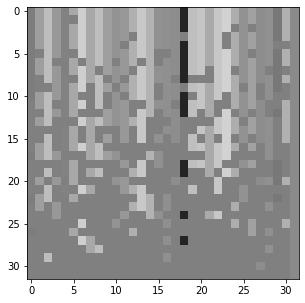

127 tensor([0.2129, 0.7871]) pred: 1 label: -1


In [244]:
import torch

subdir = 'model-mlp-32-sz-2500-lr-decay-0.1'
i = 812
vocab = vocabs[subdir]
df_i = pd.DataFrame([df.iloc[i]])
x, y = dataloader(df_i, vocab, ns=[1,3])
xd = np.copy(x)


class MLPHook(torch.nn.Module):

    def __init__(self, dim_in, dim_h, dim_out):
        super(MLPHook, self).__init__()
        self.fc = nn.Linear(dim_in, dim_h)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm1d(dim_h)
        self.dense = nn.Linear(dim_h, dim_out)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, ablation):
        x = x.to(torch.float)
        x = self.fc(x)
        x *= ablation
        c = x.clone()
        x = self.relu(x)
        x = self.bn(x)
        x = self.dense(x)
        return x, c

dim_h = int(subdir.split('mlp-')[1].split('-')[0])
dim_in, dim_h, dim_out = (len(vocabs[subdir]), dim_h, 2)
net = MLPHook(dim_in, dim_h, dim_out)

fp = os.path.join('./output', subdir, 'weights.pt')
state_dict = torch.load(fp)

net.load_state_dict(state_dict)
import matplotlib as mpl
activations = []
scores = []
for sz in range(0, dim_h, 1):
    ablation = torch.ones((1, dim_h))
    ix = torch.Tensor(np.random.choice(np.arange(dim_h-1), sz, replace=False)).to(torch.long)
    ablation[:, ix] = 0
    # print(ablation)
    net.eval()
    with torch.no_grad():
        xi = torch.Tensor(xd)
        output, activation = net(xi, ablation)

    score = torch.softmax(output, 1)
    pred = -1 if torch.argmax(output, 1)[0] == 0 else 1
    
    print(score, f'pred: {pred}',  f'label: {y[0]}')
    print()
    scores.append(score)
    activations.append(activation.flatten().numpy())
        
fig, ax = plt.subplots(figsize=(7, 5))
ax.imshow(
    np.stack(activations, 0),
    cmap='gray',
    norm=mpl.colors.Normalize(vmin=-1.,vmax=1.))
plt.show()

agg_score = torch.cat(scores).mean(0)
pred = -1 if torch.argmax(agg_score, 0).item == 0 else 1
print(f'{len(ix_tokens)} {agg_score} pred: {pred}',  f'label: {y[0]}')

Populating feature vectors...


1it [00:00, 32.82it/s]

0
tensor([[8.7940e-04, 9.9912e-01]]) pred: 1 label: -1

10
tensor([[0.0016, 0.9984]]) pred: 1 label: -1

20
tensor([[0.0109, 0.9891]]) pred: 1 label: -1

30
tensor([[0.0108, 0.9892]]) pred: 1 label: -1

40
tensor([[0.0192, 0.9808]]) pred: 1 label: -1

50
tensor([[0.0313, 0.9687]]) pred: 1 label: -1

60
tensor([[0.0376, 0.9624]]) pred: 1 label: -1

70
tensor([[0.1530, 0.8470]]) pred: 1 label: -1

80
tensor([[0.1528, 0.8472]]) pred: 1 label: -1

90
tensor([[0.1081, 0.8919]]) pred: 1 label: -1



Populating feature vectors...


1it [00:00, 34.69it/s]

0


tensor([[9.9998e-01, 2.0667e-05]]) pred: -1 label: -1

10
tensor([[9.9999e-01, 7.2981e-06]]) pred: -1 label: -1

20
tensor([[9.9999e-01, 5.3616e-06]]) pred: -1 label: -1

30
tensor([[9.9999e-01, 1.0060e-05]]) pred: -1 label: -1

40
tensor([[9.9997e-01, 2.5144e-05]]) pred: -1 label: -1

50
tensor([[9.9991e-01, 9.1616e-05]]) pred: -1 label: -1

60
tensor([[9.9958e-01, 4.2128e-04]]) pred: -1 label: -1

70
tensor([[0.9970, 0.0030]]) pred: -1 label: -1

80
tensor([[0.9946, 0.0054]]) pred: -1 label: -1

90
tensor([[0.9910, 0.0090]]) pred: -1 label: -1

Populating feature vectors...


1it [00:00, 32.52it/s]


0
tensor([[0.0036, 0.9964]]) pred: 1 label: -1

10
tensor([[0.0247, 0.9753]]) pred: 1 label: -1

20
tensor([[0.0273, 0.9727]]) pred: 1 label: -1

30
tensor([[0.6206, 0.3794]]) pred: -1 label: -1

40
tensor([[0.4638, 0.5362]]) pred: 1 label: -1

50
tensor([[0.7312, 0.2688]]) pred: -1 label: -1

60
tensor([[0.9561, 0.0439]]) pred: -1 label: -1

70
tensor([[0.9543, 0.0457]]) pred: -1 label: -1

80
tensor([[0.9468, 0.0532]]) pred: -1 label: -1

90
tensor([[0.9508, 0.0492]]) pred: -1 label: -1



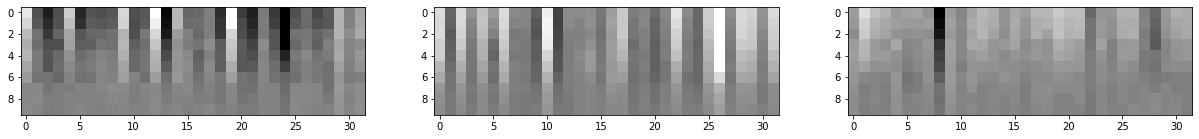

152 tensor([0.5396, 0.4604])  pred: -1 label: -1


In [200]:
import torch
sample_ix = 2883


class MLPHook(torch.nn.Module):

    def __init__(self, dim_in, dim_h, dim_out):
        super(MLPHook, self).__init__()
        self.fc = nn.Linear(dim_in, dim_h)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm1d(dim_h)
        self.dense = nn.Linear(dim_h, dim_out)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.to(torch.float)
        x = self.fc(x)
        c = x.clone()
        x = self.relu(x)
        x = self.bn(x)
        x = self.dense(x)
        return x, c
    

subdirs = [
    'model-mlp-author-h-32-ngrams-1-w-100',
    'model-mlp-32-sz-2500-ngrams-1-3-tf-15',
    'model-mlp-32-sz-2500-ngrams-1-3-5-tf-15']

nets = {}
for i, subdir in enumerate(subdirs):
    dim_h = 32
    dim_in, dim_h, dim_out = (len(vocabs[subdir]), dim_h, 2)
    net = MLPHook(dim_in, dim_h, dim_out)
    
    fp = os.path.join('./output', subdir, 'weights.pt')
    if not os.path.exists(fp):
        fp = os.path.join('./output', subdir, 'state_dict-f0.pt')
    state_dict = torch.load(fp)

    net.load_state_dict(state_dict)
    
    nets[subdir] = net

ens_scores = []
fig, ax = plt.subplots(1, len(subdirs), figsize=(21, 7))

for i, subdir in enumerate(subdirs):

    vocab = vocabs[subdir]
    df_i = pd.DataFrame([df.iloc[sample_ix]])
    x, y = dataloader(df_i, vocab, ns=[1,3])
    xd = np.copy(x)

    import matplotlib as mpl
    activations = []
    scores = []
    for d_out in range(0, 100, 10):
        ix_tokens = x.nonzero()[1]
        ix_dropout = np.random.choice(ix_tokens, d_out)
        xd[:, ix_dropout] = 0

        net = nets[subdir]
        net.eval()
        with torch.no_grad():
            xi = torch.Tensor(xd)
            output, activation = net(xi)

        score = torch.softmax(output, 1)
        pred = -1 if torch.argmax(output, 1)[0] == 0 else 1

        print(d_out)
        print(score, f'pred: {pred}',  f'label: {y[0]}')
        print()
        scores.append(score)
        activations.append(activation.flatten().numpy())

    agg_score = torch.cat(scores).mean(0)
    ens_scores.append(agg_score)
    ax[i].imshow(
        np.stack(activations, 0),
        cmap='gray',
        norm=mpl.colors.Normalize(vmin=-1.,vmax=1.))

plt.show()

ens_score = torch.stack(ens_scores).mean(0)
pred = -1 if torch.argmax(ens_score, 0).item() == 0 else 1
print(f'{len(ix_tokens)} {ens_score}  pred: {pred}',  f'label: {y[0]}')

In [95]:
import torch

data_dir = os.path.abspath('./data')
dev_fp = os.path.join(data_dir, 'phase1.dev.shuf.tsv')
df = get_dataframe(dev_fp)

class MLPHook(torch.nn.Module):

    def __init__(self, dim_in, dim_h, dim_out):
        super(MLPHook, self).__init__()
        self.fc = nn.Linear(dim_in, dim_h)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm1d(dim_h)
        self.dense = nn.Linear(dim_h, dim_out)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.to(torch.float)
        x = self.fc(x)
        c = x.clone()
        x = self.relu(x)
        x = self.bn(x)
        x = self.dense(x)
        return x, c
    

subdirs = [
    'model-mlp-author-h-32-ngrams-1-w-100',
    'model-mlp-32-sz-2500-ngrams-1-3-tf-15',
    'model-mlp-32-sz-2500-ngrams-1-3-5-tf-15']
ns = [[1,], [1,3], [1,3,5]]

nets = {}
vocs = {}
for i, subdir in enumerate(subdirs):
    nets[subdir] = {}
    vocs[subdir] = {}
    
    vocab = vocabs[subdir]
  
    fp = os.path.join('./output', subdir, 'weights.pt')
    if not os.path.exists(fp):
        folds = list(range(5))
    else:
        folds = [0,]
    for fold in folds:
        if len(folds) > 1:
            # fold vocab
            fp = os.path.join(dir_output, subdir, f'vocabulary-f{fold}.csv')
            with open(fp, 'r') as f:
                vocab = [line.strip() for line in f.readlines()]
            # fold state dict
            fp = os.path.join('./output', subdir, f'state_dict-f{fold}.pt')
        else:
            pass
        
        dim_h = 32
        dim_in, dim_h, dim_out = (len(vocab), dim_h, 2)
        net = MLPHook(dim_in, dim_h, dim_out)
    
        state_dict = torch.load(fp)
        net.load_state_dict(state_dict)
    
        nets[subdir][fold] = net
        vocs[subdir][fold] = vocab

ens_stack = []

for i, subdir in enumerate(subdirs):
    xd = {}
    ens_pred = []
    
    folds = vocs[subdir].keys()
    for fold in folds:
        x, y = dataloader(ens_frame, vocs[subdir][fold], ns=ns[i], add_authors='author' in subdir)
        xd[fold] = np.copy(x)

    for sample_ix in range(len(ens_frame)):
        scores_d = []
        for d_out in range(0, 100, 10):
            scores = []
            for fold in range(len(nets[subdir].keys())):
                sample = xd[fold][sample_ix][None, :]
                ix_tokens = sample.nonzero()[0]
                ix_dropout = np.random.choice(ix_tokens, d_out)
                sample[:, ix_dropout] = 0

                net = nets[subdir][fold]
                net.eval()
                with torch.no_grad():
                    xi = torch.Tensor(sample)
                    output, activation = net(xi)
                    score = torch.softmax(output, 1)
                    
                scores.append(score)
                
            agg_score = torch.cat(scores).mean(0)
            scores_d.append(agg_score)

        score_d = torch.stack(scores_d).mean(0)

        ens_pred.append(score_d[1].item())
        
    ens_stack.append(ens_pred)
    


In [78]:
new_preds = np.stack([np.array(stack) for stack in ens_stack], 1).mean(1)

In [79]:
ens_frame['ens_score'] = new_preds

In [85]:
ens_frame['score_mix'] = (ens_frame['score'] + ens_frame['ens_score']) / 2

In [88]:
new_preds = np.stack([np.array(stack) for stack in ens_stack], 1).mean(1)
ens_frame['ens_score'] = new_preds
ens_frame['score_mix'] = (ens_frame['score'] + ens_frame['ens_score']) / 2

rows = []
for score_col in ['score', 'ens_score', 'score_mix']:
    y_true, y_prob = ens_frame['assessment'], ens_frame[score_col]
    x,y,_ = metrics.roc_curve(y_true, y_prob, pos_label=1)
    auc = metrics.auc(x, y)
    t = 0.50
    tn = (ens_frame[score_col] < t) & (ens_frame['assessment'] == -1)
    fp = (ens_frame[score_col] >= t) & (ens_frame['assessment'] == -1)    
    fn = (ens_frame[score_col] < t) & (ens_frame['assessment'] == 1)
    tp = (ens_frame[score_col] >= t) & (ens_frame['assessment'] == 1)    
    row = {}
    row['tn'] = sum(tn)
    row['fp'] = sum(fp)
    row['fn'] = sum(fn)
    row['tp'] = sum(tp)
    row['auc'] = auc
    row['exp'] = score_col
    rows.append(row)
ens_stats = pd.DataFrame(rows)

In [89]:
ens_stats['specificity'] = ens_stats['tn'] / (ens_stats['tn'] + ens_stats['fp']) 
ens_stats['precision'] = ens_stats['tp'] / (ens_stats['tp'] + ens_stats['fp']) 
ens_stats['recall'] = ens_stats['tp'] / (ens_stats['tp'] + ens_stats['fn']) 
ens_stats['f1'] = (2 * ens_stats['precision'] * ens_stats['recall']) / (ens_stats['precision'] + ens_stats['recall']) 
ens_stats.fillna(0, inplace=True)
ens_stats

,tn,fp,fn,tp,auc,exp,specificity,precision,recall,f1
0,4591,109,50,100,0.948694,score,0.976809,0.478469,0.666667,0.557103
1,4662,38,96,54,0.919626,ens_score,0.991915,0.586957,0.360000,0.446281
2,4639,61,78,72,0.944787,score_mix,0.987021,0.541353,0.480000,0.508834


In [636]:
import torch

fold = 1
voc_fp = os.path.join(dir_output, subdir, f'vocabulary-f{fold}.csv')
if os.path.exists(voc_fp):
    with open(voc_fp, 'r') as f:
        vocab = [line.strip() for line in f.readlines()]
    

class MLPHook(torch.nn.Module):

    def __init__(self, dim_in, dim_h, dim_out):
        super(MLPHook, self).__init__()
        self.fc = nn.Linear(dim_in, dim_h)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm1d(dim_h)
        self.dense = nn.Linear(dim_h, dim_out)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = x.to(torch.float)
        x = self.fc(x)
        c = x.clone()
        x = self.relu(x)
        x = self.bn(x)
        x = self.dense(x)
        return x, c

subdir = 'model-mlp-author-h-32-ngrams-1-w-100'
dim_h = 32
dim_in, dim_h, dim_out = (len(vocab), dim_h, 2)
net = MLPHook(dim_in, dim_h, dim_out)

fp = os.path.join('./output', subdir, f'state_dict-f{fold}.pt')
state_dict = torch.load(fp)

net.load_state_dict(state_dict)

ix_important = [vocab.index(term) for term in important]
dist = -distance_matrix(w_pca[ix_important, :], w_pca, p=1)
topk_dists = np.argpartition(dist, 200, axis=1)[:, :200]
ix_topk_dists = list(np.unique(topk_dists))

rows = []
fp = (pred_frame['score'] >= 0.5) & (pred_frame['assessment'] == -1)
tp = (pred_frame['score'] >= 0.5) & (pred_frame['assessment'] == 1)
fn = (pred_frame['score'] < 0.5) & (pred_frame['assessment'] == 1)
tn = (pred_frame['score'] < 0.5) & (pred_frame['assessment'] == -1)
conds = [('fp', fp), ('tp', tp), ('fn', fn), ('tn', tn)]
for cond_label, cond in conds:
    for c, i in enumerate(pred_frame[cond].sort_values(by='score', ascending=False).index):
        if c > 200:
            break
        df_i = pd.DataFrame([pred_frame.iloc[i]])
        x, y = dataloader(df_i, vocab, ns=[1,], add_authors=True)
        xd = np.copy(x)

        for d_in in [1, 3, 5]:
            for d_out in [1, 3, 5, 10, 20, 30, 40, 50]:
                ix_tokens = x.nonzero()[1]
                ix_dropout = np.random.choice(ix_tokens, d_out)
                if cond_label in ('fp', 'tp'):
                    ix_nontokens = ix_important
                else:
                    ix_nontokens = ix_topk_dists
                ix_dropin = np.random.choice(ix_nontokens, d_in)
                xd[:, ix_dropout] = 0
                xd[:, ix_dropin] = 1

                net.eval()
                with torch.no_grad():
                    xi = torch.Tensor(xd)
                    output, activation = net(xi)
                    prob = torch.softmax(output.detach(), 1)[0][1].item()

                pred = -1 if torch.argmax(output, 1)[0] == 0 else 1
                row = {
                    'cond': cond_label,
                    'index': i,
                    'd_out': d_out,
                    'd_in': d_in,
                    'prob': prob,
                }

                # activations.append(activation.flatten().numpy())
                rows.append(row)


In [637]:
ablate_df = pd.DataFrame(rows)

In [638]:
ablate_df = ablate_df.groupby(['cond', 'd_out', 'd_in']).agg(['mean', 'std'])['prob'].reset_index()

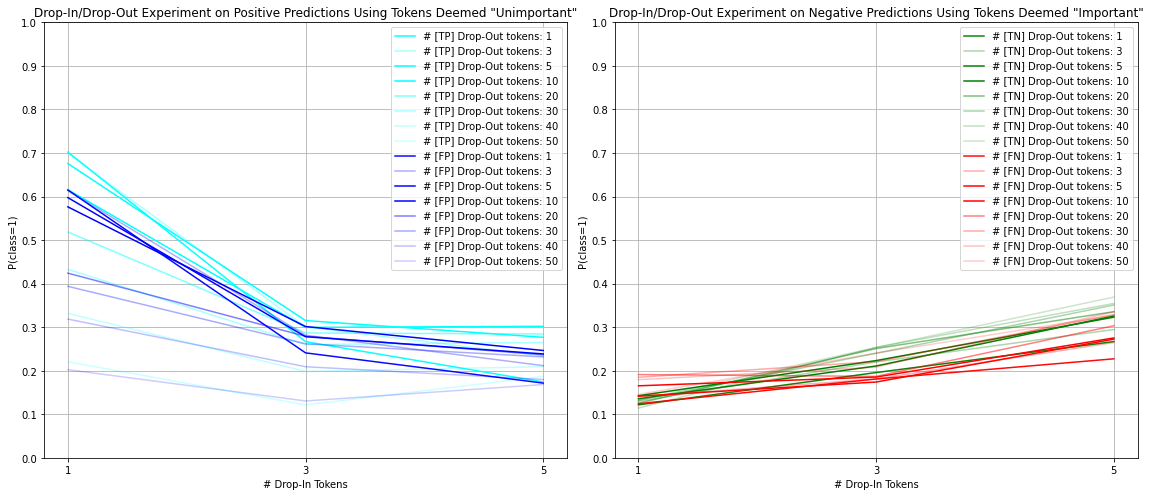

In [639]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

ablate_df_cond = ablate_df[ablate_df['cond'] == 'tp']
for d_out in ablate_df_cond['d_out'].unique():
    ablate_d_out = ablate_df_cond[ablate_df_cond['d_out'] == d_out]
    ablate_d_out = ablate_d_out.sort_values(by='d_in')
    ax[0].plot(
        ablate_d_out['d_in'], ablate_d_out['mean'], color='cyan',
        alpha=1/(0.1*d_out), label=f'# [TP] Drop-Out tokens: {d_out}')



ablate_df_cond = ablate_df[ablate_df['cond'] == 'fp']
for d_out in ablate_df_cond['d_out'].unique():
    ablate_d_out = ablate_df_cond[ablate_df_cond['d_out'] == d_out]
    ablate_d_out = ablate_d_out.sort_values(by='d_in')
    ax[0].plot(
        ablate_d_out['d_in'], ablate_d_out['mean'], color='blue',
        alpha=1/(0.1*d_out), label=f'# [FP] Drop-Out tokens: {d_out}')

ax[0].legend()
ax[0].set_xticks(ablate_d_out['d_in'])
ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[0].set_xlabel('# Drop-In Tokens')
ax[0].set_ylabel('P(class=1)')
ax[0].set_ylim(0, 1)
ax[0].grid()
ax[0].set_title('Drop-In/Drop-Out Experiment on Positive Predictions Using Tokens Deemed "Unimportant"')


ablate_df_cond = ablate_df[ablate_df['cond'] == 'tn']
for d_out in ablate_df_cond['d_out'].unique():
    ablate_d_out = ablate_df_cond[ablate_df_cond['d_out'] == d_out]
    ablate_d_out = ablate_d_out.sort_values(by='d_in')
    ax[1].plot(
        ablate_d_out['d_in'], ablate_d_out['mean'], color='green',
        alpha=1/(0.1*d_out), label=f'# [TN] Drop-Out tokens: {d_out}')


ablate_df_cond = ablate_df[ablate_df['cond'] == 'fn']
for d_out in ablate_df_cond['d_out'].unique():
    ablate_d_out = ablate_df_cond[ablate_df_cond['d_out'] == d_out]
    ablate_d_out = ablate_d_out.sort_values(by='d_in')
    ax[1].plot(
        ablate_d_out['d_in'], ablate_d_out['mean'], color='red',
        alpha=1/(0.1*d_out), label=f'# [FN] Drop-Out tokens: {d_out}')

ax[1].legend()
ax[1].set_xticks(ablate_d_out['d_in'])
ax[1].set_yticks(np.arange(0, 1.1, 0.1))
ax[1].set_xlabel('# Drop-In Tokens')
ax[1].set_ylabel('P(class=1)')
ax[1].set_ylim(0, 1)
ax[1].grid()
ax[1].set_title('Drop-In/Drop-Out Experiment on Negative Predictions Using Tokens Deemed "Important"')

fig.tight_layout()
plt.show()

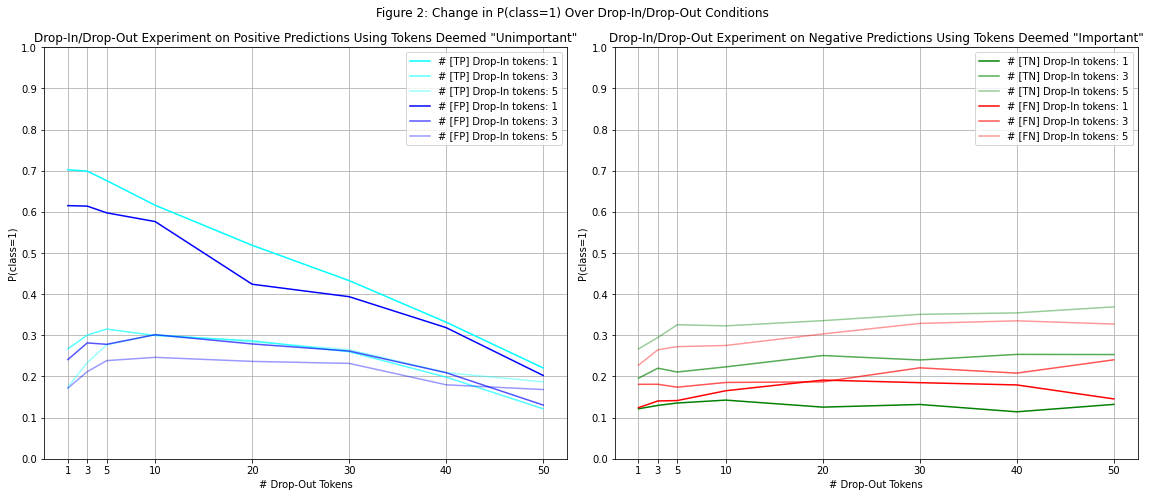

In [644]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))

ablate_df_cond = ablate_df[ablate_df['cond'] == 'tp']
for d_in in ablate_df_cond['d_in'].unique():
    ablate_d_in = ablate_df_cond[ablate_df_cond['d_in'] == d_in]
    ablate_d_in = ablate_d_in.sort_values(by='d_out')
    ax[0].plot(
        ablate_d_in['d_out'], ablate_d_in['mean'], color='cyan',
        alpha=1/(d_in*0.5), label=f'# [TP] Drop-In tokens: {d_in}')



ablate_df_cond = ablate_df[ablate_df['cond'] == 'fp']
for d_in in ablate_df_cond['d_in'].unique():
    ablate_d_in = ablate_df_cond[ablate_df_cond['d_in'] == d_in]
    ablate_d_in = ablate_d_in.sort_values(by='d_out')
    ax[0].plot(
        ablate_d_in['d_out'], ablate_d_in['mean'], color='blue',
        alpha=1/(d_in*0.5), label=f'# [FP] Drop-In tokens: {d_in}')

ax[0].legend()
ax[0].set_xticks(ablate_d_in['d_out'])
ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[0].set_xlabel('# Drop-Out Tokens')
ax[0].set_ylabel('P(class=1)')
ax[0].set_ylim(0, 1)
ax[0].grid()
ax[0].set_title('Drop-In/Drop-Out Experiment on Positive Predictions Using Tokens Deemed "Unimportant"')


ablate_df_cond = ablate_df[ablate_df['cond'] == 'tn']
for d_in in ablate_df_cond['d_in'].unique():
    ablate_d_in = ablate_df_cond[ablate_df_cond['d_in'] == d_in]
    ablate_d_in = ablate_d_in.sort_values(by='d_out')
    ax[1].plot(
        ablate_d_in['d_out'], ablate_d_in['mean'], color='green',
        alpha=1/(d_in*0.5), label=f'# [TN] Drop-In tokens: {d_in}')


ablate_df_cond = ablate_df[ablate_df['cond'] == 'fn']
for d_in in ablate_df_cond['d_in'].unique():
    ablate_d_in = ablate_df_cond[ablate_df_cond['d_in'] == d_in]
    ablate_d_in = ablate_d_in.sort_values(by='d_out')
    ax[1].plot(
        ablate_d_in['d_out'], ablate_d_in['mean'], color='red',
        alpha=1/(d_in*0.5), label=f'# [FN] Drop-In tokens: {d_in}')

ax[1].legend()
ax[1].set_xticks(ablate_d_in['d_out'])
ax[1].set_yticks(np.arange(0, 1.1, 0.1))
ax[1].set_xlabel('# Drop-Out Tokens')
ax[1].set_ylabel('P(class=1)')
ax[1].set_ylim(0, 1)
ax[1].grid()
ax[1].set_title('Drop-In/Drop-Out Experiment on Negative Predictions Using Tokens Deemed "Important"')
fig.suptitle('Figure 2: Change in P(class=1) Over Drop-In/Drop-Out Conditions')
fig.tight_layout()
plt.show()

In [806]:
import torch

data_dir = os.path.abspath('./data')
dev_fp = os.path.join(data_dir, 'phase1.dev.shuf.tsv')
df = get_dataframe(dev_fp)

class MLPHook(torch.nn.Module):

    def __init__(self, dim_in, dim_h, dim_out):
        super(MLPHook, self).__init__()
        self.fc = nn.Linear(dim_in, dim_h)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm1d(dim_h)
        self.dense = nn.Linear(dim_h, dim_out)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, ablation):
        x = x.to(torch.float)
        x = self.fc(x)
        x *= ablation
        c = x.clone()
        x = self.relu(x)
        x = self.bn(x)
        x = self.dense(x)
        return x, c
    

subdirs = [
    'model-mlp-author-h-32-ngrams-1-w-100',
    'model-mlp-32-sz-2500-ngrams-1-3-tf-15',
    'model-mlp-32-sz-2500-ngrams-1-3-5-tf-15']
ns = [[1,], [1,3], [1,3,5]]

nets = {}
vocs = {}
for i, subdir in enumerate(subdirs):
    nets[subdir] = {}
    vocs[subdir] = {}
    
    vocab = vocabs[subdir]
  
    fp = os.path.join('./output', subdir, 'weights.pt')
    if not os.path.exists(fp):
        folds = list(range(5))
    else:
        folds = [0,]
        
    for fold in folds:
        if len(folds) > 1:
            # fold vocab
            fp = os.path.join(dir_output, subdir, f'vocabulary-f{fold}.csv')
            with open(fp, 'r') as f:
                vocab = [line.strip() for line in f.readlines()]
            # fold state dict
            fp = os.path.join('./output', subdir, f'state_dict-f{fold}.pt')
        else:
            pass
        
        dim_h = 32
        dim_in, dim_h, dim_out = (len(vocab), dim_h, 2)
        net = MLPHook(dim_in, dim_h, dim_out)
    
        state_dict = torch.load(fp)
        net.load_state_dict(state_dict)
    
        nets[subdir][fold] = net
        vocs[subdir][fold] = vocab
        
fp = (pred_frame['score'] >= 0.5) & (pred_frame['assessment'] == -1) 
fn = (pred_frame['score'] < 0.5) & (pred_frame['assessment'] == 1) 
tp = (pred_frame['score'] >= 0.5) & (pred_frame['assessment'] == 1) 
tn = (pred_frame['score'] < 0.5) & (pred_frame['assessment'] == -1) 

conds = [('fp', fp), ('fn', fn), ('tp', tp), ('tn', tn)]

scalars = [-1, 0, 0.1]

rows = []
folds = [0,]
# for fold in folds:
#     x, y = dataloader(pred_frame, vocs[subdirs[0]][fold], ns=ns[i], add_authors=True)
#     xd[fold] = np.copy(x)
    


for c, index in enumerate(pred_frame.index):
    
    if (pred_frame.loc[index]['score'] >= 0.5) & (pred_frame.loc[index]['assessment'] == -1):
        cond = 'fp'
    elif (pred_frame.loc[index]['score'] >= 0.5) & (pred_frame.loc[index]['assessment'] == 1):
        cond = 'tp'
    elif (pred_frame.loc[index]['score'] < 0.5) & (pred_frame.loc[index]['assessment'] == -1):
        cond = 'tn'
    else:
        cond = 'fn'
    
    for i, subdir in enumerate(subdirs[:1]):

        # folds = vocs[subdir].keys()

        for scalar in scalars:
            ablation_modes = [(0,), (1,), (-1,), (2,), (3,)]
            for modes in ablation_modes:
                # print(modes)
                # print()
                for k in [0, 1, 3, 5, 10]:

                    for mode in modes:

                        scores = []
                        for fold in folds:
                            sample = xd[fold][index]

                            ablation = torch.ones((1, dim_h))
                            if mode == -1:
                                ix = np.random.choice(np.arange(dim_h-1), k, replace=False)
                            # positive bias
                            elif mode == 0:
                                ix = np.argsort(topk_diff_fp_tn)[-k:]
                            # negative bias
                            elif mode == 1:
                                ix = np.argsort(topk_diff_fn_tp)[-k:]
                            # fp bias
                            elif mode == 2:
                                ix = np.argsort(topk_diff_fp_tp)[-k:]
                            # fn bias
                            elif mode == 3:
                                ix = np.argsort(topk_diff_fn_tn)[-k:]
                            # no bias
                            else:
                                ix = []
                            ix = torch.Tensor(ix).to(torch.long) 
                            ablation[:, ix] *= scalar
                            if (k != 0) and (len(ix) > 0):
                                net = nets[subdir][fold]
                                net.eval()
                                with torch.no_grad():
                                    xi = torch.Tensor(sample)
                                    output, activation = net(xi.unsqueeze(0), ablation)
                                    score = torch.softmax(output, 1)
                            else:
                                score = pred_frame.loc[index]['score']
                                score = torch.Tensor([[1 - score, score]])
                            scores.append(score)

                    agg_score = torch.cat(scores).mean(0)

                    prob = agg_score[1].item()

                    row = {
                        'index': index,
                        'cond': cond,
                        'modes': modes,
                        'k': k,
                        'scalar': scalar,
                        'prob': prob}
                    rows.append(row)
                        # print(modes, k, scalar, pred)
                # print()

In [807]:
ablate_exp = pd.DataFrame(rows)

In [808]:
ablate_exp = ablate_exp.groupby(['modes', 'k', 'scalar', 'cond']).mean()['prob'].to_frame().reset_index()

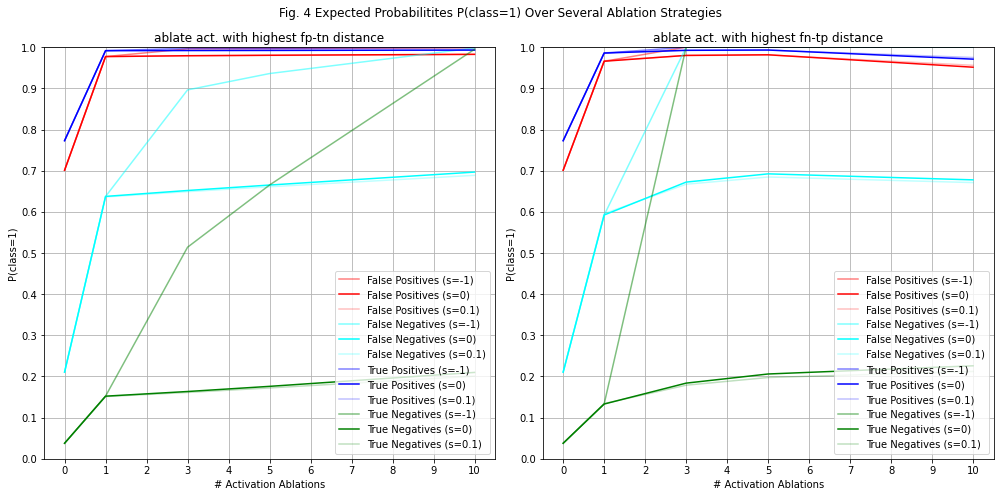

In [838]:
desc = {
    (-1,): 'random ablation',
    (0,): 'ablate act. with highest fp-tn distance',
    (1,): 'ablate act. with highest fn-tp distance',
    (2,): 'ablate act. with highest fp-tp distance',
    (3,): 'ablate act. with highest fn-tn distance',
    (4,): 'no ablation'}
colors = {
    'fp': 'red',
    'tp': 'blue',
    'fn': 'cyan',
    'tn': 'green',}
alphas = {
    -1: 0.5,
    0.1: 0.25,
    0.0: 1.0
}
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
for c, modes in enumerate(ablation_modes[:2]):
    for i, cond in enumerate([cond[0] for cond in conds]):
        subexp_mode = ablate_exp[(ablate_exp['modes'] == modes) & (ablate_exp['cond'] == cond)]
        for scalar in scalars:
            subexp = subexp_mode[subexp_mode['scalar'] == scalar]
            ax[c].plot(
                subexp['k'],
                subexp['prob'],
                label=f'{cond_desc[cond]} (s={scalar})',
                color=colors[cond], alpha=alphas[scalar])
    ax[c].set_title(desc[modes])
    ax[c].grid()
    ax[c].legend()
    ax[c].set_ylim(0.0, 1.0)
    ax[c].set_yticks(np.arange(0, 1.1, .1))
    ax[c].set_xticks(np.arange(0, 11, 1))
    ax[c].set_xlabel('# Activation Ablations')
    ax[c].set_ylabel('P(class=1)')
fig.suptitle('Fig. 4 Expected Probabilitites P(class=1) Over Several Ablation Strategies')
fig.tight_layout()        
fig.patch.set_facecolor('white')

In [903]:
import torch

data_dir = os.path.abspath('./data')
dev_fp = os.path.join(data_dir, 'phase1.dev.shuf.tsv')
df = get_dataframe(dev_fp)

class MLPHook(torch.nn.Module):

    def __init__(self, dim_in, dim_h, dim_out):
        super(MLPHook, self).__init__()
        self.fc = nn.Linear(dim_in, dim_h)
        self.relu = nn.LeakyReLU()
        self.bn = nn.BatchNorm1d(dim_h)
        self.dense = nn.Linear(dim_h, dim_out)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, ix, patch):
        x = x.to(torch.float)
        x = self.fc(x)
        if len(ix) > 0:
            x[:, ix] = patch
        c = x.clone()
        x = self.relu(x)
        x = self.bn(x)
        x = self.dense(x)
        return x, c
    

subdirs = [
    'model-mlp-author-h-32-ngrams-1-w-100',
    'model-mlp-32-sz-2500-ngrams-1-3-tf-15',
    'model-mlp-32-sz-2500-ngrams-1-3-5-tf-15']
subdir = subdirs[0]

pred_frame = pred_frames[subdir].reset_index()
# pred_frame = pred_frame.merge(train_df.reset_index()[['index', 'authors']], on='index')

ns = [[1,], [1,3], [1,3,5]]

nets = {}
vocs = {}
for i, subdir in enumerate(subdirs[:1]):
    nets[subdir] = {}
    vocs[subdir] = {}
    
    vocab = vocabs[subdir]
  
    fp = os.path.join('./output', subdir, 'weights.pt')
    if not os.path.exists(fp):
        folds = list(range(5))
    else:
        folds = [0,]
    for fold in folds:
        if len(folds) > 1:
            # fold vocab
            fp = os.path.join(dir_output, subdir, f'vocabulary-f{fold}.csv')
            with open(fp, 'r') as f:
                vocab = [line.strip() for line in f.readlines()]
            # fold state dict
            fp = os.path.join('./output', subdir, f'state_dict-f{fold}.pt')
        else:
            pass
        
        dim_h = 32
        dim_in, dim_h, dim_out = (len(vocab), dim_h, 2)
        net = MLPHook(dim_in, dim_h, dim_out)
    
        state_dict = torch.load(fp)
        net.load_state_dict(state_dict)
    
        nets[subdir][fold] = net
        vocs[subdir][fold] = vocab
        
fp = (pred_frame['score'] >= 0.5) & (pred_frame['assessment'] == -1) 
fn = (pred_frame['score'] < 0.5) & (pred_frame['assessment'] == 1) 
tp = (pred_frame['score'] >= 0.5) & (pred_frame['assessment'] == 1) 
tn = (pred_frame['score'] < 0.5) & (pred_frame['assessment'] == -1) 

conds = [('fp', fp), ('fn', fn), ('tp', tp), ('tn', tn)]
folds = [0,]
rows = []

for c, index in enumerate(pred_frame.index):
    
    if (pred_frame.loc[index]['score'] >= 0.5) & (pred_frame.loc[index]['assessment'] == -1):
        cond = 'fp'
    elif (pred_frame.loc[index]['score'] >= 0.5) & (pred_frame.loc[index]['assessment'] == 1):
        cond = 'tp'
    elif (pred_frame.loc[index]['score'] < 0.5) & (pred_frame.loc[index]['assessment'] == -1):
        cond = 'tn'
    else:
        cond = 'fn'

    patch_modes = [(0,), (1,), (2,), (3,), (4,)]

    for modes in patch_modes:

        for k in [0, 1, 3, 5, 10, 25, 32]:
            # track average probs at each level of k 

            scores = []
            for mode in modes:

                for fold in [0,]:#range(len(nets[subdir].keys())):

                    # xd[fold] = np.copy(x)
                    sample = xd[fold][index]

                    # patch strong tn into fp
                    if mode == 0:
                        ix = np.argsort(topk_diff_fp_tn)[:k]
                        patch = avg_activation[(-1, -1)][ix]
                    # patch strong tp into fn
                    elif mode == 1:
                        ix = np.argsort(topk_diff_fn_tp)[:k]
                        patch = avg_activation[(1, 1)][ix]                        
                    # replace strong fn activations with activations from tp
                    elif mode == 2:
                        ix = np.argsort(topk_diff_fn_tp)[-k:]
                        patch = avg_activation[(1, 1)][ix]
                    # replace strong fp activations with activations from tn
                    elif mode == 3:
                        ix = np.argsort(topk_diff_fp_tn)[-k:]
                        patch = avg_activation[(-1, -1)][ix]
                    # no patch
                    else:
                        ix = []
                        patch = []
                    ix = torch.Tensor(ix).to(torch.long) 
                    patch = torch.Tensor(patch)
                    
                    if (k != 0) and (len(ix) > 0):
                        net = nets[subdir][fold]
                        net.eval()
                        with torch.no_grad():
                            xi = torch.Tensor(sample)
                            output, activation = net(xi.unsqueeze(0), ix, patch)
                            score = torch.softmax(output, 1)
                    else:
                        score = pred_frame.loc[index]['score']
                        score = torch.Tensor([[1 - score, score]])

                    scores.append(score)

            agg_score = torch.cat(scores).mean(0)

            prob = agg_score[1].item()

            row = {
                'index': index,
                'cond': cond,
                'modes': modes,
                'k': k,
                'prob': prob}

            rows.append(row)
                        

In [904]:
patch_exp = pd.DataFrame(rows)
patch_exp = patch_exp.groupby(['modes', 'k', 'cond']).agg(['mean', 'std'])['prob'].reset_index()

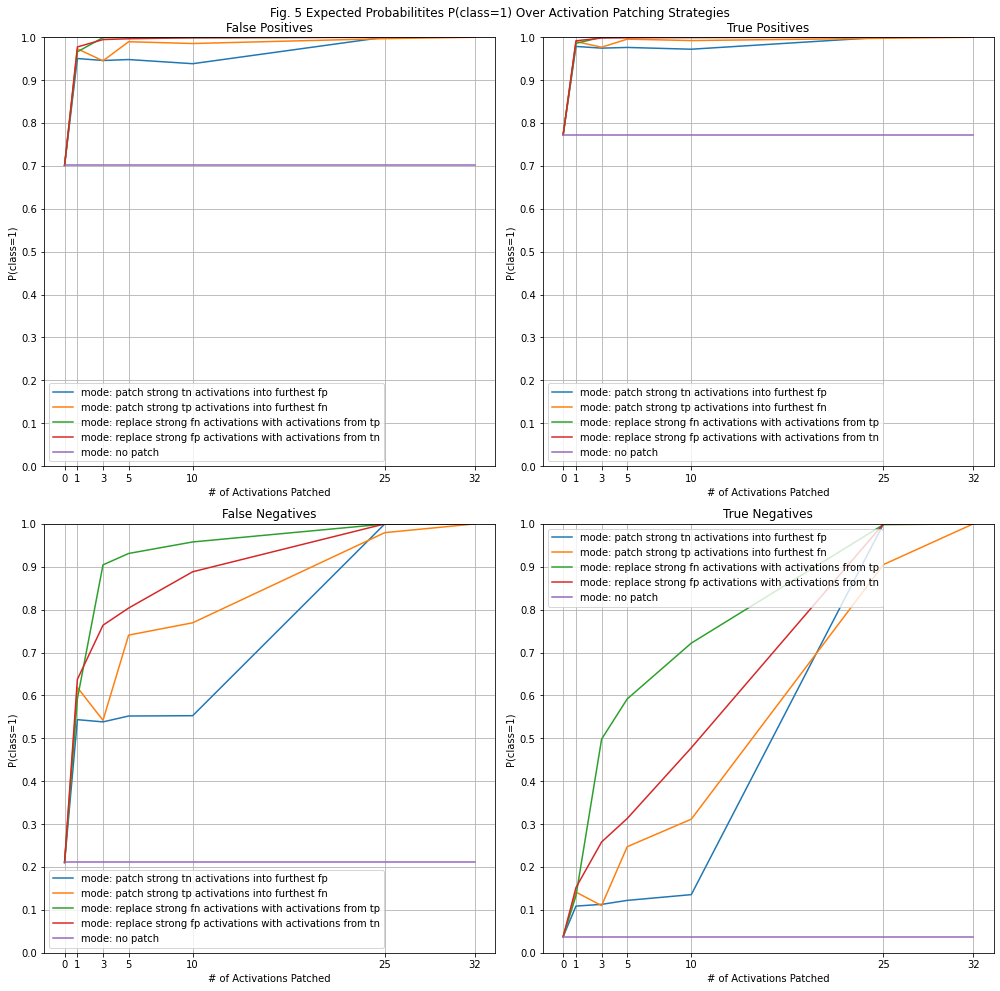

In [905]:
desc = {
    (0,): 'patch strong tn activations into furthest fp',
    (1,): 'patch strong tp activations into furthest fn',
    (2,): 'replace strong fn activations with activations from tp',
    (3,): 'replace strong fp activations with activations from tn',
    (4,): 'no patch'}
cond_desc = {
    'fp': 'False Positives',
    'tp': 'True Positives',
    'fn': 'False Negatives',
    'tn': 'True Negatives',
}
fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for c, cond in enumerate(['fp', 'tp', 'fn', 'tn']):
    r = c // 2
    c = c % 2
    for i, modes in enumerate(patch_modes):
        subexp_mode = patch_exp[(patch_exp['cond'] == cond) & (patch_exp['modes'] == modes)]
        ax[r, c].plot(subexp_mode['k'], subexp_mode['mean'], label=f'mode: {desc[modes]}')
    ax[r, c].set_title(cond_desc[cond])
    ax[r, c].grid()
    ax[r, c].set_yticks(np.arange(0, 1.1, 0.1))
    ax[r, c].set_xticks([0, 1, 3, 5, 10, 25, 32])
    ax[r, c].set_xlabel('# of Activations Patched')
    ax[r, c].set_ylabel('P(class=1)')
    ax[r, c].legend()
    ax[r, c].set_ylim(0.0, 1.0)
fig.suptitle('Fig. 5 Expected Probabilitites P(class=1) Over Activation Patching Strategies')
fig.tight_layout()
fig.patch.set_facecolor('white')

In [906]:
patch_exp = pd.DataFrame(rows)

In [910]:
patch_exp = patch_exp.merge(pred_frame[['index', 'assessment']])

In [1003]:
x_prototype = torch.Tensor(avg_activation[(1, 1)]).unsqueeze(0)
with torch.no_grad():
    x_prototype = net.relu(x_prototype)
    x_prototype = net.bn(x_prototype)
    output = x_prototype.matmul(net.dense.weight.t()) + net.dense.bias
print(torch.softmax(output, 1))

tensor([[1.2561e-04, 9.9987e-01]])
